# TextRank

In [139]:
import numpy as np
import pandas as pd
import config
import jupyter_service
import sys
import matplotlib.pyplot as plt
from dbcontext import Context
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.display.float_format = '{:.2f}'.format
print(sys.version, np.__version__, pd.__version__, config.version)

3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)] 2.0.2 2.2.3 0.1.0.Alpha


In [2]:
context = Context()
context.create(echo=False)
service = jupyter_service.JupyterService(context)
print(config.connection_string)

postgresql://postgres:sa@localhost:5432/yt1


Most used topics

In [187]:
sql = """SELECT avg(count) as average, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY count) as median_, PERCENTILE_CONT(0.25) WITHIN GROUP(ORDER BY count) as quartile, PERCENTILE_CONT(0.1) WITHIN GROUP(ORDER BY count) as decile, PERCENTILE_CONT(0.01) WITHIN GROUP(ORDER BY count) as percentile FROM topic where source='textrank' and count > 1"""
df = service.get_by_sql(sql)
avg=57
median=6
percentile=2
nb_topic=588
nb_form=15854
df

,average,median_,quartile,decile,percentile
0,57.02,6.00,3.00,2.00,2.00


In [129]:
sql = """select label, count from topic where source='textrank' and count > 1 order by count desc"""
df = service.get_by_sql(sql)
df

,label,count
0,peace,2924
1,countries,2239
2,world,2076
3,life,1752
4,good,1543
...,...,...
853,cambio,2
854,heroic,2
855,madness,2
856,turmoil,2


Most used topics by forms

In [47]:
sql = """select topic.label, count(form_topic.id) as nb_form from topic
join form_topic on form_topic.topic_id=topic.id
where source='textrank'
group by topic.id
order by nb_form desc"""
df = service.get_by_sql(sql)
df.head(10)

,label,nb_form
0,peace,2898
1,world,2039
2,countries,2026
3,life,1702
4,good,1517
5,happiness,1330
6,people,1209
7,health,1183
8,better,1132
9,respect,1061


Lemas

In [137]:
topic = "peace"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)


,topic_label,lema_label,count
0,peace,peace,2802
1,peace,world_peace,350
2,peace,peaceful,209
3,peace,more_peace,37
4,peace,inner_peace,25
5,peace,quiet,21
6,peace,secure,16
7,peace,peacefull,16
8,peace,serenity,14
9,peace,more_peaceful,13


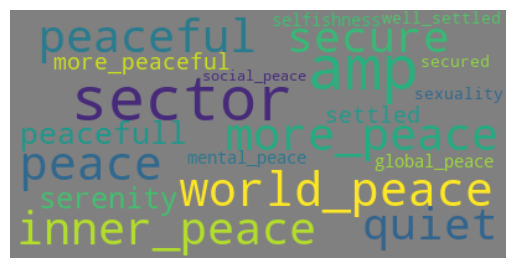

In [37]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [217]:
empathy_category="f"

Empathy Negative Score

In [218]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_neg_form, sub_topic.nb_form, power(count(form_topic.id)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and stat.{empathy_category}_category=0
and form_topic.question_nb=12
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)


,id,label,nb_neg_form,nb_form,ratio
0,5980,peace,290,2898,29.02
1,5960,life,188,1702,20.77
2,5955,countries,196,2026,18.96
3,5998,world,187,2039,17.15
4,6021,good,158,1517,16.46
5,6048,happiness,134,1330,13.50
6,6049,health,120,1183,12.17
7,5999,success,99,929,10.55
8,5987,better,101,1132,9.01
9,5978,development,75,631,8.91


In [219]:
topic = "countries"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
df.head(10)

,topic_label,lema_label,count
0,countries,countries,120
1,countries,comfort,115
2,countries,community,84
3,countries,conditions,70
4,countries,comfortable,52
5,countries,corruption,50
6,countries,company,48
7,countries,mutual,45
8,countries,common,42
9,countries,conflicts,42


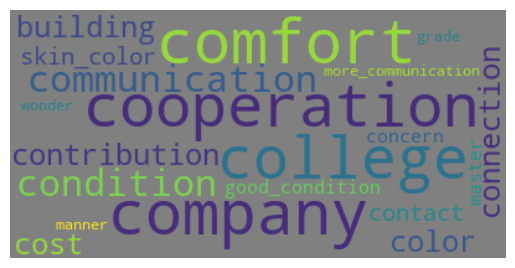

In [220]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

PD Positive Score

In [221]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_pos_form, sub_topic.nb_form, power(count(form_topic.id)::float,2)/sub_topic.nb_form as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > {avg}
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and form_topic.question_nb=12
and stat.{empathy_category}_category=2
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {median}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
0,5980,peace,1488,2898,764.02
1,5998,world,1084,2039,576.29
2,5955,countries,1046,2026,540.04
3,5960,life,868,1702,442.67
4,6021,good,783,1517,404.15
5,6048,happiness,708,1330,376.89
6,6012,people,670,1209,371.30
7,5987,better,610,1132,328.71
8,6049,health,606,1183,310.43
9,5964,respect,573,1061,309.45


In [222]:
topic = "peace"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
# df["lema_label"] = df["lema_label"].str.replace('_',' ')
df.head(10)

,topic_label,lema_label,count
0,peace,peace,2802
1,peace,world_peace,350
2,peace,peaceful,209
3,peace,more_peace,37
4,peace,inner_peace,25
5,peace,quiet,21
6,peace,secure,16
7,peace,peacefull,16
8,peace,serenity,14
9,peace,more_peaceful,13


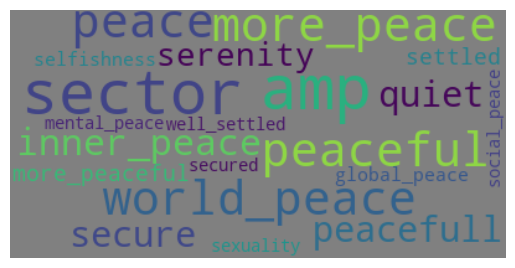

In [223]:
text = ""
for index, row in df.iterrows():
    text += row.lema_label + " "
wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="grey").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Low Noise
857 topics
Low noise = 8
Very low = 1


In [224]:
low_noise = median
very_low_noise = percentile
thresold = nb_form / 1000
thresold, low_noise, very_low_noise

(15.85, 6, 2)

In [225]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_neg_form, sub_topic.nb_form, log(power(count(form_topic.id)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < {avg}
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and form_topic.question_nb=12
and stat.{empathy_category}_category=0
group by topic.id, sub_topic.nb_form
having count(form_topic.id) >= {very_low_noise}
order by ratio desc"""
df = service.get_by_sql(sql)
df = df[df.label != "etre"]
df.head(10)

,id,label,nb_neg_form,nb_form,ratio
0,6812,lebanon,2,2,-0.26
1,6469,nurse,2,3,-0.69
2,6862,gestures,2,3,-0.69
3,6297,germany,2,3,-0.69
4,6567,elimination,2,4,-1.12
5,6648,wrong,2,4,-1.12
6,6332,sincerity,3,5,-1.20
7,6111,apartment,2,5,-1.55
8,6138,aider,2,5,-1.55
9,6416,soldier,2,5,-1.55


In [226]:
topic = "millionaire"
sql = f"""select topic.label as topic_label, lema.label as lema_label, lema.count from topic
join lema on lema.topic_id=topic.id
where topic.label = '{topic}'
and source='textrank'
order by lema.count desc"""
df = service.get_by_sql(sql)
df.head(10)

,topic_label,lema_label,count
0,millionaire,millionaire,21
1,millionaire,minimal,11
2,millionaire,minded,11
3,millionaire,middle,9
4,millionaire,minds,7
5,millionaire,minority,6
6,millionaire,open_minded,6
7,millionaire,mistakes,6
8,millionaire,million,5
9,millionaire,minimum,5


In [227]:
sql = f"""select topic.id, topic.label, count(form_topic.id) as nb_pos_form, sub_topic.nb_form, log(power(count(form_topic.id)::float,2)/power(2.7, sub_topic.nb_form)) as ratio from topic
join form_topic on form_topic.topic_id=topic.id
join form on form_topic.form_id=form.id
join stat on stat.id=form.id
join (select topic.id, count(form_topic.id) as nb_form from topic
	join form_topic on form_topic.topic_id=topic.id
	join form on form_topic.form_id=form.id
	join stat on stat.id=form.id
	where source='textrank'
    and form_topic.question_nb=12
	group by topic.id
	having count(form_topic.id) > 1 and count(form_topic.id) < {avg}
) sub_topic on sub_topic.id = topic.id
where source='textrank'
and form_topic.question_nb=12
and stat.{empathy_category}_category=2
group by topic.id, sub_topic.nb_form
having count(form_topic.id) > {low_noise}
order by ratio desc"""
df = service.get_by_sql(sql)
df.head(10)

,id,label,nb_pos_form,nb_form,ratio
0,6570,lawyer,7,9,-2.19
1,6775,amazing,8,10,-2.51
2,6505,talents,7,10,-2.62
3,6790,management,7,10,-2.62
4,7131,gods,7,10,-2.62
5,6259,france,7,11,-3.05
6,6909,insecurity,7,11,-3.05
7,6842,truth,11,12,-3.09
8,6536,members,9,12,-3.27
9,6506,game,8,12,-3.37
